# 08: Soft-Sand, Stiff-Sand and Cemented sand models 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['font.size']=14
plt.rcParams['font.family']='arial'

<div class="alert alert-block alert-success">
<b>Learning Objectives:</b>
<ul>
    <li>Soft-sand model</li>
    <li>Stiff-sand model</li>
    <li>Contact cement model</li>
    <li>Constant cement model</li>
    <li>Increasing cement model</li>
    <li>Rock physics diagnostic approach</li>
</ul>
</div>

## Soft-Sand model

In Walton and Hertz–Mindlin contact models, the porosity is fixed at a critical porosity $\phi_c \approx 0.4$ for randomly densed packed spheres of equal size. To find the effective moduli of unconsolidated sand at a different porosity $\phi$, a heuristic modified Hashin–Shtrikman lower bound is used as an interpolator between the
Hertz–Mindlin moduli $K_{HM}$ and $\mu_{HM}$ at porosity $\phi_c$ and the solid grain moduli $K$ and $\mu$ at zero porosity, the elastic moduli at different porosity can be computed as:

$
K_{\mathrm{eff}}=\left[\frac{\phi / \phi_{c}}{K_{\mathrm{HM}}+\frac{4}{3} \mu_{\mathrm{HM}}}+\frac{1-\phi / \phi_{c}}{K+\frac{4}{3} \mu_{\mathrm{HM}}}\right]^{-1}-\frac{4}{3} \mu_{\mathrm{HM}}
$

$
\mu_{\mathrm{eff}}=   \left[\frac{\phi / \phi_{c}}{\mu_{\mathrm{HM}}+\frac{\mu_{\mathrm{HM}}}{6}\left(\frac{9 K_{\mathrm{HM}}+8 \mu_{\mathrm{HM}}}{K_{\mathrm{HM}}+2 \mu_{\mathrm{HM}}}\right)}+\frac{1-\phi / \phi_{c}}{\mu+\frac{\mu_{\mathrm{HM}}}{6}\left(\frac{9 K_{\mathrm{HM}}+8 \mu_{\mathrm{HM}}}{K_{\mathrm{HM}}+2 \mu_{\mathrm{HM}}}\right)}\right]^{-1} -\frac{\mu_{\mathrm{HM}}}{6}\left(\frac{9 K_{\mathrm{HM}}+8 \mu_{\mathrm{HM}}}{K_{\mathrm{HM}}+2 \mu_{\mathrm{HM}}}\right) 
$

where $K$ and $\mu$ are bulk and shear moduli of grain material, repectively. 

Soft-sand model is also called unconsolidated sand model or friable sand model e.g. in Avseth et al. (2010).

In [2]:
def hertzmindlin(K0, G0, phic, Cn, sigma, f):
    """Compute effective elastic moduli of granular packing via Hertz-Mindlin approach. Written by Jiaxin Yu. 07.2021. 

    Args:
        K0 (GPa): bulk modulus of grain material
        G0 (GPa): shear modulus of grain material
        phic (GPa): critical porosity
        Cn (unitless): coordination number
        sigma (MPa): effective stress
        f (unitless): reduced shear factor, 0=dry pack with inifinitely rough spheres; 1=dry pack with infinitely smooth spheres

    Returns:
        K_dry, G_dry: effective elastic moduli of dry pack
    
    """    
    sigma =sigma/1000 # converts pressure unit to GPa
    nu=(3*K0-2*G0)/(6*K0+2*G0) # poisson's ratio of mineral mixture
    K_dry = (sigma*(Cn**2*(1-phic)**2*G0**2) / (18*np.pi**2*(1-nu)**2))**(1/3)
    G_dry = ((2+3*f-nu*(1+3*f))/(5*(2-nu))) * ((sigma*(3*Cn**2*(1-phic)**2*G0**2)/(2*np.pi**2*(1-nu)**2)))**(1/3)
    return K_dry, G_dry
def softsand(K0, G0, phi, phic, Cn, sigma, f):
    """Soft-sand (unconsolidated sand) model: model the porosity-sorting effects using the lower Hashin–Shtrikman–Walpole bound. (Also referred to as the ‘friable-sand model’ in Avseth et al. 2010). Written by Jiaxin Yu (July 2021)

    Args:
        K0 (GPa): Bulk modulus of grain material
        G0 (GPa): shear modulus of grain material
        phi (float or array-like): Porosity
        phic (frac): depositional porosity, Defaults to 0.4.
        Cn (unitless): coordination number Defaults to 8.6.
        sigma (MPa): effective stress. 
        f (unitless): reduced shear factor. 0=dry pack with inifinitely rough spheres; 1=dry pack with infinitely smooth spheres
    Returns:
        K_dry, G_dry (GPa): Effective elastic moduli of dry pack
    """   
    K_HM, G_HM = hertzmindlin(K0, G0, phic, Cn, sigma, f)
    K_dry =-4/3*G_HM + (((phi/phic)/(K_HM+4/3*G_HM)) + ((1-phi/phic)/(K0+4/3*G_HM)))**-1
    aux = G_HM/6*((9*K_HM+8*G_HM) / (K_HM+2*G_HM)) # auxiliary variable 
    G_dry = -aux + ((phi/phic)/(G_HM+aux) + ((1-phi/phic)/(G0+aux)))**-1
    return K_dry, G_dry

## Stiff-Sand model 
A counterpart to the soft-sand model is the “stiff-sand” model, which uses precisely the same end-members as in the soft-sand model but connects them with a heuristic modified Hashin–Shtrikman upper bound as a stiff interpolator: 

$
K_{\mathrm{eff}}=\left[\frac{\phi / \phi_{c}}{K_{\mathrm{HM}}+\frac{4}{3} \mu}+\frac{1-\phi / \phi_{c}}{K+\frac{4}{3} \mu}\right]^{-1}-\frac{4}{3} \mu
$

$
\mu_{\mathrm{eff}}=   \left[\frac{\phi / \phi_{c}}{\mu_{\mathrm{HM}}+\frac{\mu}{6}\left(\frac{9 K+8 \mu}{K+2 \mu}\right)}+\frac{1-\phi / \phi_{c}}{\mu+\frac{\mu}{6}\left(\frac{9 K+8 \mu}{K+2 \mu}\right)}\right]^{-1}-\frac{\mu}{6}\left(\frac{9 K+8 \mu}{K+2 \mu}\right) 
$


In [3]:
def stiffsand(K0, G0, phi, phic, Cn, sigma, f):
    """Stiff-sand model: model the porosity-sorting effects using the lower Hashin–Shtrikman–Walpole bound. Written by Jiaxin Yu (July 2021)

    Args:
        K0 (GPa): Bulk modulus of grain material
        G0 (GPa): shear modulus of grain material
        phi (float or array-like): Porosity
        phic (frac): depositional porosity, Defaults to 0.4.
        Cn (unitless): coordination number Defaults to 8.6.
        sigma (MPa): effective stress. 
        f (unitless): reduced shear factor. 0=dry pack with inifinitely rough spheres; 1=dry pack with infinitely smooth spheres

    Returns:
        K_dry, G_dry (GPa): Effective elastic moduli of dry pack
    """    
    K_HM, G_HM = hertzmindlin(K0, G0, phic, Cn, sigma, f)
    K_dry = -4/3*G0 + (((phi/phic)/(K_HM+4/3*G0)) + ((1-phi/phic)/(K0+4/3*G0)))**-1
    aux = G0/6*((9*K0+8*G0) / (K0+2*G0))
    G_dry = -aux + ((phi/phic)/(G_HM+aux) + ((1-phi/phic)/(G0+aux)))**-1
    return K_dry, G_dry

## Dvorkin’s Cemented-Sand Model
Soft- and Stiff-Sand models describe how the elastic moduli of unconsolidated sand vary in the porosity-stress plane. Dvorkin’s Cemented-Sand Model instead allows us to compute the moduli of sand pack in which the cement deposits at the *grain contact*. As a result, this model is also called **Contact cement model**. The contact cement fills the crack-like spaces near the grain contacts. This has the effect of very rapidly stiffening the rock
with very little change in porosity. This cement tends to eliminate further sensitivity. In this model, the effective bulk modulus $K_{dry}$ and shear modulus $G_{dry}$ of dry rock are:

$K_{\mathrm{eff}}=\frac{1}{6} C\left(1-\phi_{0}\right) M_{\mathrm{c}} \hat{S}_{\mathrm{n}}$

$\mu_{\mathrm{eff}}=\frac{3}{5} K_{\mathrm{eff}}+\frac{3}{20} C\left(1-\phi_{0}\right) \mu_{\mathrm{c}} \hat{S}_{\tau}$ 

$M_c= K_c+ \frac{4\mu_c}{3}$

where $\phi_c$ is critical porosity; Ks and µs are the bulk and shear moduli of the grain material, respectively; $K_c$ and $\mu_c$ are the bulk and shear moduli of the cement material, respectively; $M_c$ is the compressional modulus of the cement; and n is the coordination number. The parameters $ \hat{S}_{\mathrm{n}}$ and $ \hat{S}_{\tau}$ are:

$\hat{S}_{\mathrm{n}}=A_{\mathrm{n}} \alpha^{2}+B_{\mathrm{n}} \alpha+C_{\mathrm{n}}$

$A_{\mathrm{n}}=-0.024153 \Lambda_{\mathrm{n}}^{-1.3646}$

$B_{\mathrm{n}}=0.20405 \Lambda_{\mathrm{n}}^{-0.89008}$

$C_{\mathrm{n}}=0.00024649 \Lambda_{\mathrm{n}}^{-1.9864}$

$\hat{S}_{\tau}=A_{\tau} \alpha^{2}+B_{\tau} \alpha+C_{\tau}$

$A_{\tau}=-10^{-2}\left(2.26 v^{2}+2.07 v+2.3\right) \Lambda_{\tau}^{0.079 v^{2}+0.1754 v-1.342}$

$B_{\tau}=\left(0.0573 v^{2}+0.0937 v+0.202\right) \Lambda_{\tau}^{0.0274 v^{2}+0.0529 v-0.8765}$

$C_{\tau}=10^{-4}\left(9.654 v^{2}+4.945 v+3.1\right) \Lambda_{\tau}^{0.01867 v^{2}+0.4011 v-1.8186}$

$\Lambda_{\mathrm{n}}=\frac{2 \mu_{\mathrm{c}}}{\pi \mu} \frac{(1-v)\left(1-v_{\mathrm{c}}\right)}{\left(1-2 v_{\mathrm{c}}\right)}$

$\Lambda_{\tau}=\frac{\mu_{\mathrm{c}}}{\pi \mu}$

$\alpha=\frac{a}{R}$

By assuming that porosity reduction in sands is due to cementation
only, we can relate the parameter $\alpha$ to the current porosity of cemented sand $\phi$. For Scheme 1 in which all cement is deposited at grain contacts

$
\alpha=2\left[\frac{\phi_{0}-\phi}{3 C\left(1-\phi_{0}\right)}\right]^{1 / 4}=2\left[\frac{S \phi_{0}}{3 C\left(1-\phi_{0}\right)}\right]^{1 / 4}
$

For scheme 2, in which cement is evenly deposited on the grain surface:

$
\alpha=\left[\frac{2\left(\phi_{0}-\phi\right)}{3\left(1-\phi_{0}\right)}\right]^{1 / 2}=\left[\frac{2 S \phi_{0}}{3\left(1-\phi_{0}\right)}\right]^{1 / 2}
$

<img src='contact_cement.PNG' style='width:300px;height:100px'/>

From The handbook of rock physics (Mavko, 2020)

In [4]:
def contactcement(K0, G0, Kc, Gc, phi, phic, Cn,  scheme):
    """Compute dry elastic moduli of cemented sandstone via Contact cement (cemented sand) model, Dvorkin-Nur (1996). Written by Jiaxin Yu (July 2021)

    Args:
        K0 (GPa): Bulk modulus of grain material
        G0 (GPa): shear modulus of grain material
        Kc (GPa): Bulk modulus of cement
        Gc (GPa): shear modulus of cement
        phi (float or array-like): Porosity
        phic (frac): depositional porosity, Defaults to 0.4.
        Cn (unitless): coordination number Defaults to 8.6.
        scheme: Scheme of cement deposition
                1=cement deposited at grain contacts
                2=cement deposited at grain surfaces
    Returns:
        K_dry, G_dry (GPa): Effective elastic moduli of dry rock
    """    
    nu_0=(3*K0-2*G0)/(6*K0+2*G0) # Poisson's ratio of grain material
    nu_c = (3*Kc-2*Gc)/(6*Kc+2*Gc) # Poisson's ratio of cement
    if scheme == 1: # scheme 1: cement deposited at grain contacts
        alpha = 2*((phic-phi)/(3*Cn*(1-phic))) ** (1/4)
    else: # scheme 2: cement evenly deposited on grain surface
        alpha = ((2*(phic-phi))/(3*(1-phic)))**(1/2)
    LambdaN = (2*Gc*(1-nu_0)*(1-nu_c)) / (np.pi*G0*(1-2*nu_c))
    N1 = -0.024153*LambdaN**-1.3646
    N2 = 0.20405*LambdaN**-0.89008
    N3 = 0.00024649*LambdaN**-1.9864
    Sn = N1*alpha**2 + N2*alpha + N3
    LambdaT = Gc/(np.pi*G0)
    T1 = -10**-2*(2.26*nu_0**2+2.07*nu_0+2.3)*LambdaT**(0.079*nu_0**2+0.1754*nu_0-1.342)
    T2 = (0.0573*nu_0**2+0.0937*nu_0+0.202)*LambdaT**(0.0274*nu_0**2+0.0529*nu_0-0.8765)
    T3 = 10**-4*(9.654*nu_0**2+4.945*nu_0+3.1)*LambdaT**(0.01867*nu_0**2+0.4011*nu_0-1.8186)
    St = T1*alpha**2 + T2*alpha + T3
    K_dry = 1/6*Cn*(1-phic)*(Kc+(4/3)*Gc)*Sn
    G_dry = 3/5*K_dry+3/20*Cn*(1-phic)*Gc*St
    return K_dry, G_dry

## Constant cement model 
As introduced by Avseth et al. (2000), Constant cement model assumes that sands of varying porosity all have the same amount of contact cement. Porosity variation is solely due to non-contact pore-filling material (e.g., deteriorating sorting). This model is contact cement model blend with soft-sand model at an adjusted high porosity end memeber $\phi_b$. Firstly, porosity reduces from the initial sand-pack porosity to porosity
$\phi_b$, dry-rock bulk and shear moduli at this porosity ($K_b$ and $\mu_b$, respectively) are calculated
from the contact-cement model. Then the dry-rock bulk $K_{dry}$ and shear $\mu_{dry}$
moduli at a smaller porosity $\phi$ are then interpolated with a lower Hashin-Strikmann bound:

$
K_{\mathrm{dry}}=\left[\frac{\phi / \phi_{\mathrm{b}}}{K_{\mathrm{b}}+(4 / 3) \mu_{\mathrm{b}}}+\frac{1-\phi / \phi_{\mathrm{b}}}{K+(4 / 3) \mu_{\mathrm{b}}}\right]^{-1}-\frac{4}{3} \mu_{\mathrm{b}}
$

$
\mu_{\mathrm{dry}}=\left[\frac{\phi / \phi_{\mathrm{b}}}{\mu_{\mathrm{b}}+z}+\frac{1-\phi / \phi_{\mathrm{b}}}{\mu+z}\right]^{-1}-z$, $z=\frac{\mu_{\mathrm{b}}}{6}\left(\frac{9 K_{\mathrm{b}}+8 \mu_{\mathrm{b}}}{K_{\mathrm{b}}+2 \mu_{\mathrm{b}}}\right)
$

In [5]:
def constantcement(phi_b, K0, G0, Kc, Gc,phi, phic, Cn,scheme):
    """Constant cement (constant depth) model according to Avseth (2000)
       https://doi.org/10.1190/1.3483770. Written by Jiaxin Yu (July 2021)

    Args:
        phi_b (frac): adjusted high porosity end memeber
        K0 (GPa): Bulk modulus of grain material
        G0 (GPa): shear modulus of grain material
        Kc (GPa): Bulk modulus of cement
        Gc (GPa): shear modulus of cement
        phi (float or array-like): Porosity
        phic (frac): depositional porosity, Defaults to 0.4.
        Cn (unitless): coordination number Defaults to 8.6.
        scheme: Scheme of cement deposition
                1=cement deposited at grain contacts
                2=cement deposited at grain surfaces
    Returns:
        K_dry, G_dry (GPa): Effective elastic moduli of dry rock
    """    
    K_b,G_b=contactcement(K0, G0, Kc, Gc, phi_b, phic, Cn,  scheme)
    T=phi/phi_b
    Z=(G_b/6)*(9*K_b+8*G_b)/(K_b+2*G_b)
    Kdry=(T/(K_b+4*G_b/3)+(1-T)/(K0+4*G_b/3))**(-1)-4*G_b/3
    Gdry=(T/(G_b+Z)+(1-T)/(G0+Z))**(-1)-Z

    return Kdry, Gdry  
    

## Increasing cement model 
The contact cement model represents the initial stage of the “diagenetic trend” in the data. It is found to be applicable to high-porosity sands. During more severe cementation where the diagenetic cement is filling up the pore space, the contact theory breaks down. One should use  the modified Hashin–Shtrikman upper bound (also referred to as the “increasingcement model). The high-porosity end member is determined by contact
theory. The first 2–3% cement should be modeled with the contact-cement model. Further increase in cement volume and decrease in porosity is described by an HS upper bound interpolation between the high-porosity end member and the mineral point. 


In [6]:
def MUHS(K0, G0, Kc,Gc,phi, phi_b,phic, Cn,scheme):
   """Increasing cement model: Modified Hashin-Strikmann upper bound blend with contact cement model. Written by Jiaxin Yu (July 2021)
   
   Args:
      K0 (GPa): Bulk modulus of grain material
      G0 (GPa): shear modulus of grain material
      Kc (GPa): Bulk modulus of cement
      Gc (GPa): shear modulus of cement
      phi (float or array-like): Porosity
      phi_b (frac): adjusted high porosity end memeber
      phic (frac): depositional porosity, Defaults to 0.4.
      Cn (unitless): coordination number Defaults to 8.6.
      scheme: Scheme of cement deposition
                1=cement deposited at grain contacts
                2=cement deposited at grain surfaces
   Returns:
      K_dry, G_dry (GPa): Effective elastic moduli of dry rock
   """   
   # adjusted high porosity end memeber 
   K_b, G_b=contactcement(K0, G0, Kc, Gc, phi_b, phic, Cn, scheme)
   # interpolation between the high-porosity end member Kb, Gb and the mineral point. 
   K_dry = -4/3*G0 + (((phi/phi_b)/(K_b+4/3*G0)) + ((1-phi/phi_b)/(K0+4/3*G0)))**-1
   tmp = G0/6*((9*K0+8*G0) / (K0+2*G0))
   G_dry = -tmp + ((phi/phi_b)/(G_b+tmp) + ((1-phi/phi_b)/(G0+tmp)))**-1
   return K_dry, G_dry

## Examples
* Let's compute effective bulk and shear moduli of a water saturated rock using different bound models.

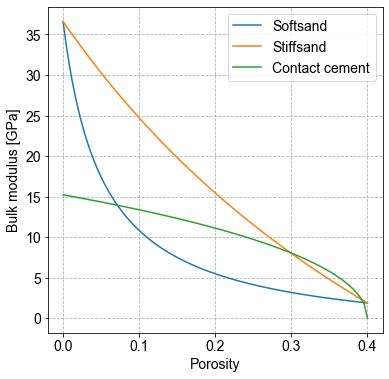

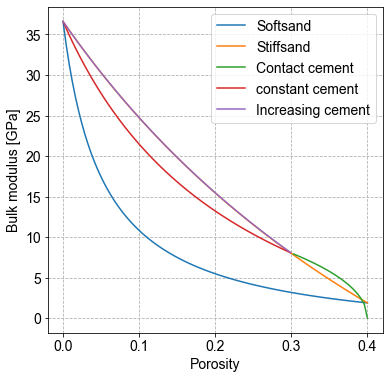

In [7]:
# specify model parameters
phic=0.4 # critical porosity
sigma=20 # effective pressure 
Cn=8.6 #coordination number
f=0.5# reduced shear factor
phi = np.linspace(1e-7,phic,100) #define porosity range according to critical porosity
K0, G0 = 36.6, 45 ## grain density, bulk and shear modulus 
Kc, Gc = 36.6, 45 # cement density, bulk and shear modulus
vsh=0 # shale volume
phib=0.3 # critical cement porosity
## softsand, stiffsand and contact cement model
Kdry1, Gdry1 = softsand(K0, G0, phi, phic, Cn, sigma,f) 
Kdry2, Gdry2 = stiffsand(K0, G0, phi, phic, Cn, sigma,f)
Kdry3, Gdry3 = contactcement(K0, G0, Kc, Gc, phi, phic, Cn,  scheme=2)
# plot
plt.figure(figsize=(6,6))
plt.xlabel('Porosity')
plt.ylabel('Bulk modulus [GPa]')
plt.title('')
plt.plot(phi, Kdry1,label='Softsand')
plt.plot(phi, Kdry2,label='Stiffsand')
plt.plot(phi, Kdry3,label='Contact cement')
plt.legend(loc='best')
plt.grid(ls='--')
## constant cement model
Kdry3[phi<phib]=np.nan
Kdry4, Gdry4=constantcement(phib, K0, G0,Kc,Gc, phi, phic, Cn, scheme=2)
Kdry4[phi>phib]=np.nan
## increasing cement model
Kdry5, Gdry5 = MUHS(K0, G0, Kc,Gc,phi, phib,phic, Cn, scheme=2)
Kdry5[phi>phib]=np.nan
#plot
plt.figure(figsize=(6,6))
plt.xlabel('Porosity')
plt.ylabel('Bulk modulus [GPa]')
plt.title('')
plt.plot(phi, Kdry1,label='Softsand')
plt.plot(phi, Kdry2,label='Stiffsand')
plt.plot(phi, Kdry3,label='Contact cement')
plt.plot(phi, Kdry4,label='constant cement')
plt.plot(phi, Kdry5,label='Increasing cement')
plt.legend(loc='best')
plt.grid(ls='--')

From the figure we can see that the contact cement model will fail for small porosity sand, so we define a critical cement porosity $\phi_b$ below which constant cement model/increasing cement model can be applied. 

<div class="alert alert-block alert-info">
<b>Reference:</b> 
<ul>
    <li>Mavko, G., Mukerji, T. and Dvorkin, J., 2020. The rock physics handbook. Cambridge university press.
</li>
    <li>Avseth, P., Mukerji, T. and Mavko, G., 2010. Quantitative seismic interpretation: Applying rock physics tools to reduce interpretation risk. Cambridge university press.
</li>
</ul>
</div>